# CIFAR-10 Convolutional neural network

## Exercise - Load data

> **Exercise**: Load the CIFAR-10 data. Normalize the images and split them into train, validation and test sets. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

In [6]:
import numpy as np
import os

# Load data
with np.load(os.path.join('cifar10-60k.npz'), allow_pickle=False) as npz_file:
    cifar = dict(npz_file.items())

# Convert pixels into floating point numbers
data = cifar['data'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

data.shape

(60000, 3072)

In [9]:
from sklearn.model_selection import train_test_split
  
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Reshape images (32 by 32)
    data.reshape(-1, 32, 32, 3), # three channels (RGB)
    cifar['labels'],
    test_size=2000, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (58000, 32, 32, 3) (58000,)
Valid: (1000, 32, 32, 3) (1000,)
Test: (1000, 32, 32, 3) (1000,)


In [10]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Exercise - Create and train a ConvNet

> **Exercise:** Create a convolutional neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained kernel weights of the first convolutional layer in a variable.

In [30]:
import tensorflow as tf

# Define graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Convolution 1
    conv1 = tf.layers.conv2d(
        X, # Input data
        filters=64, # number of filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv1' # Add name
    )
    
    # Get the kernel weights
    with tf.variable_scope('conv1', reuse=True):
        conv1_kernels = tf.get_variable('kernel')
    
    # Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        conv1, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )
    
    # Convolution 2
    conv2 = tf.layers.conv2d(
        pool1, # Max pooling output
        filters=64, # number of filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )
    
    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    
    # Apply dropout
    flat_with_dropout = tf.nn.dropout(
        flat_output,
        keep_prob = 0.5)
    
     # Hidden layer with 256 units
    hidden = tf.layers.dense(
        flat_with_dropout, 256, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 10, # Output units: 10
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

## Train network

In [31]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(10):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001 # Learning rate
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
    
    # Get 1st conv. layer kernels
    kernels = conv1_kernels.eval()
    
    # Pick a sample image and get 1st conv. activations
    activation_maps = conv1.eval(feed_dict={
        X: [X_valid[300]] # Pick one image from the validation set
    })

Epoch 1 - valid: 0.501 train: 0.434 (mean)
Epoch 2 - valid: 0.590 train: 0.555 (mean)
Epoch 3 - valid: 0.647 train: 0.605 (mean)
Epoch 4 - valid: 0.667 train: 0.641 (mean)
Epoch 5 - valid: 0.667 train: 0.660 (mean)
Epoch 6 - valid: 0.680 train: 0.680 (mean)
Epoch 7 - valid: 0.679 train: 0.693 (mean)
Epoch 8 - valid: 0.687 train: 0.704 (mean)
Epoch 9 - valid: 0.697 train: 0.714 (mean)
Epoch 10 - valid: 0.711 train: 0.720 (mean)


## Exercise - Visualize kernels

> **Exercise**: Plot the kernels from the first convolutional layer with the `imshow()` function.

**Hint**: Remember that the `imshow()` function expects values between 0 and 1 for 3-dimensional arrays.

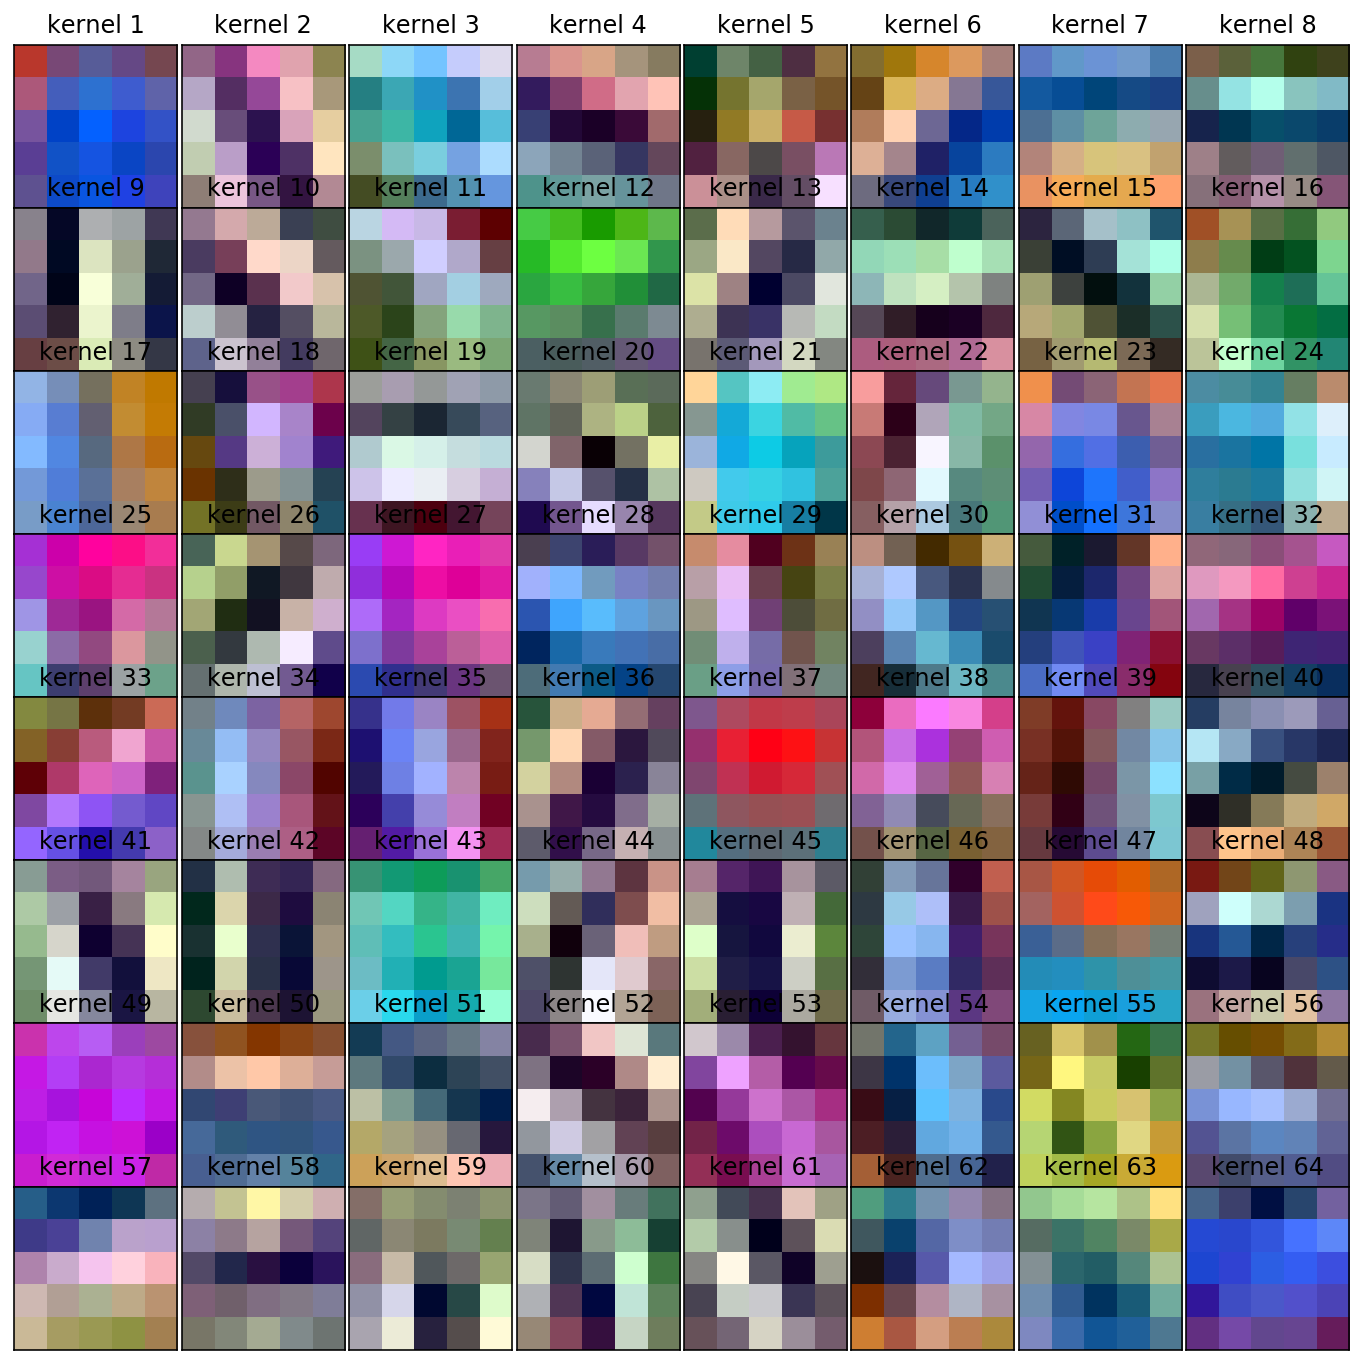

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For retina screens
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
     # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.set_title('kernel {}'.format(i+1))
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()